# Topic Modeling: OCD

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('ocd.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,8.293180e+17,294,Eora Nation,PhD candidate in gender and cultural studies @...,10/27/2021 11:59,New research out finds that #acupuncture reduc...,NaN
1,4.150866e+08,432,London,Children’s Book Illustrator 🎨 & former @pathwa...,10/27/2021 11:51,New research out finds that #acupuncture reduc...,['ocd']
2,1.311980e+18,17,NaN,One of the greatest regrets in life is being w...,10/27/2021 11:26,New research out finds that #acupuncture reduc...,['oknottobeok']
3,8.996297e+07,29198,"Boulder CO, USA",Peter Strong - Psychotherapist specializing in...,10/27/2021 11:25,New research out finds that #acupuncture reduc...,['OCD']
4,8.853120e+17,981,Hell,A free thinker and freelance writer\r\r\n\r\r\...,10/27/2021 11:06,New research out finds that #acupuncture reduc...,NaN


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=(len(data)/5), \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics, \
                       passes=20, eval_every=1, random_state=np.random.RandomState(1000))

# show keywords
print(lda_model.print_topics())

[(0, '0.028*"mentalhealth_bipolar" + 0.027*"tough_fabulous" + 0.019*"time_last" + 0.019*"issue_managed" + 0.019*"know_fucking" + 0.019*"want_make" + 0.019*"case_didn" + 0.018*"stephen_gold" + 0.018*"best_fictional" + 0.013*"night"'), (1, '0.055*"organized" + 0.055*"house" + 0.036*"help_mentalhealth" + 0.023*"evidence_back" + 0.023*"research_find" + 0.023*"acupuncture" + 0.023*"always_known" + 0.023*"ssri_performance" + 0.023*"depression" + 0.020*"back"'), (2, '0.059*"online" + 0.049*"mindfulness_therapy" + 0.038*"mindfulness" + 0.036*"therapy" + 0.029*"online_therapist" + 0.029*"obsessive_compulsive" + 0.027*"ocdrecovery_ocdawareness" + 0.027*"skype" + 0.026*"ocdrecovery" + 0.018*"obsessive"'), (3, '0.060*"hive" + 0.040*"hiveblogshare" + 0.036*"life" + 0.029*"proofofbrain" + 0.029*"community" + 0.028*"brain" + 0.028*"clean" + 0.028*"your" + 0.027*"changing" + 0.022*"posh"'), (4, '0.046*"health" + 0.040*"know" + 0.037*"condition" + 0.036*"more" + 0.036*"living" + 0.035*"ocdrecovery" + 0

### We check the accuracy of our model with coherence scores (through CV, and UMass)

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.5072563265366484


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -8.50676839221822


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=8):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=np.random.RandomState(1000))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.4765349848101776,
 0.4669659399409931,
 0.5344178676711099,
 0.47542956286842697,
 0.512108154126083,
 0.5027849389760296]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 4.

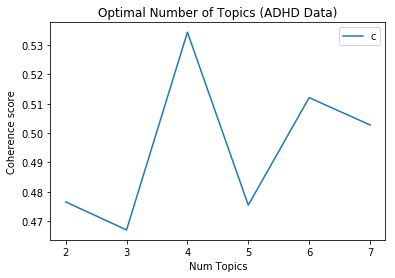

In [16]:
limit=8; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (ADHD Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.112807  0.187562       1        1  33.114849
1      0.182168 -0.031667       2        1  24.106375
3      0.113594 -0.005378       3        1  21.952029
0     -0.182955 -0.150518       4        1  20.826747, topic_info=                                                   Term        Freq  \
term                                                                  
241                                      tough_fabulous  286.000000   
380                                  hive_hiveblogshare  290.000000   
49                                               online  787.000000   
76                                  mindfulness_therapy  653.000000   
224                                      best_fictional  191.000000   
238                                        stephen_gold  191.000000   
33                                                 hive  515.000000   
213                                    online_therapist  375.000000   
53                                                skype  354.000000   
81                                 obsessive_compulsive  382.000000   
340                                mentalhealth_bipolar  351.000000   
741                                      parent_anxiety  170.000000   
132                            ocdrecovery_ocdawareness  358.000000   
738                                       adhd_selfhelp  160.000000   
50                                    online_counseling  239.000000   
509                                           feel_like  139.000000   
209                                     contact_looking  205.000000   
211                                    effective_online  205.000000   
216                                    skype_overcoming  205.000000   
133                                                adhd  230.000000   
232                                                hard  118.000000   
69                                              contact  205.000000   
45                                      depression_ptsd  222.000000   
75                                          mindfulness  554.000000   
229                                            fabulous   99.000000   
39                                                 posh  348.000000   
231                                                gold   98.000000   
271                               mindfulness_depressio  231.000000   
35                                        hiveblogshare  216.000000   
242                                     tuesdaybookblog   96.000000   
...                                                 ...         ...   
229                                            fabulous   97.922694   
239                         stephen_gold_best_fictional   95.067742   
235                                                noir   95.046694   
244                     tuesdaybookblog_pray_when_dying   94.997517   
225                                           depiction   94.927933   
231                                                gold   97.176437   
353                      ocdawareness_intrusivethoughts   46.910223   
354                              overcoming_ocdrecovery   46.880451   
240                                               tough   97.047913   
236                                                pray   96.778744   
237                                             stephen   96.752685   
230                                           fictional   96.632921   
263                                          last_night   44.966575   
355   overcoming_ocdrecovery_ocdawareness_intrusivet...   23.565233   
352                                      effective_help   23.554665   
232                                                hard  112.358577   
571                                   treatment_without   65.949594   
570                  ocdawareness_onlinetherapistforocd   22.337298   
568         

In [18]:
pyLDAvis.save_html(LDAvis_viz, 'OCD Visualization.html')

### We interpret the topics based on the keywords

In [19]:
print('1: Treatment/Online(Therapy)')
print('2: Comorbidity/Symptoms')
print('3: Sharing/Experience')
print('4: Perception/Reading')

1: Treatment/Online(Therapy)
2: Comorbidity/Symptoms
3: Sharing/Experience
4: Perception/Reading
